In [23]:
from zipfile import ZipFile

with ZipFile("/content/Dataset_archive.zip", "r") as zip_ref:
    zip_ref.extractall("/content/Dataset")

# IMPORT LIBRARIES

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings as wr
wr.filterwarnings(action="ignore")
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy import stats
from scipy.stats import skew, kurtosis

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


# DATA LOADING

In [25]:
print("="*80)
print("STEP 1: DATA LOADING")
print("="*80)

print("Loading datasets...")
account = pd.read_csv("/content/Dataset/Data/Customer Profiles/account_activity.csv")
customer = pd.read_csv("/content/Dataset/Data/Customer Profiles/customer_data.csv")
fraud = pd.read_csv("/content/Dataset/Data/Fraudulent Patterns/fraud_indicators.csv")
suspision = pd.read_csv("/content/Dataset/Data/Fraudulent Patterns/suspicious_activity.csv")
merchant = pd.read_csv("/content/Dataset/Data/Merchant Information/merchant_data.csv")
tran_cat = pd.read_csv("/content/Dataset/Data/Merchant Information/transaction_category_labels.csv")
amount = pd.read_csv("/content/Dataset/Data/Transaction Amounts/amount_data.csv")
anamoly = pd.read_csv("/content/Dataset/Data/Transaction Amounts/anomaly_scores.csv")
tran_data = pd.read_csv("/content/Dataset/Data/Transaction Data/transaction_metadata.csv")
tran_rec = pd.read_csv("/content/Dataset/Data/Transaction Data/transaction_records.csv")

# Merge customer data
costumer_data = pd.merge(customer, account, on='CustomerID')
costumer_data = pd.merge(costumer_data, suspision, on='CustomerID')

# Merge transaction data
transaction_data1 = pd.merge(fraud, tran_cat, on="TransactionID")
transaction_data2 = pd.merge(amount, anamoly, on="TransactionID")
transaction_data3 = pd.merge(tran_data, tran_rec, on="TransactionID")
transaction_data = pd.merge(transaction_data1, transaction_data2, on="TransactionID")
transaction_data = pd.merge(transaction_data, transaction_data3, on="TransactionID")

# Final merge
data = pd.merge(transaction_data, costumer_data, on="CustomerID")
print(f"Data loaded successfully: {data.shape}")
print(f"Columns: {data.columns.tolist()}")


STEP 1: DATA LOADING
Loading datasets...
Data loaded successfully: (1000, 15)
Columns: ['TransactionID', 'FraudIndicator', 'Category', 'TransactionAmount', 'AnomalyScore', 'Timestamp', 'MerchantID', 'Amount', 'CustomerID', 'Name', 'Age', 'Address', 'AccountBalance', 'LastLogin', 'SuspiciousFlag']


# EXPLORATORY DATA ANALYSIS


STEP 2: EXPLORATORY DATA ANALYSIS

Missing Values:
No missing values found

Data Types:
int64      6
object     5
float64    4
Name: count, dtype: int64

Target Distribution:
FraudIndicator
0    955
1     45
Name: count, dtype: int64
Fraud percentage: 4.50%


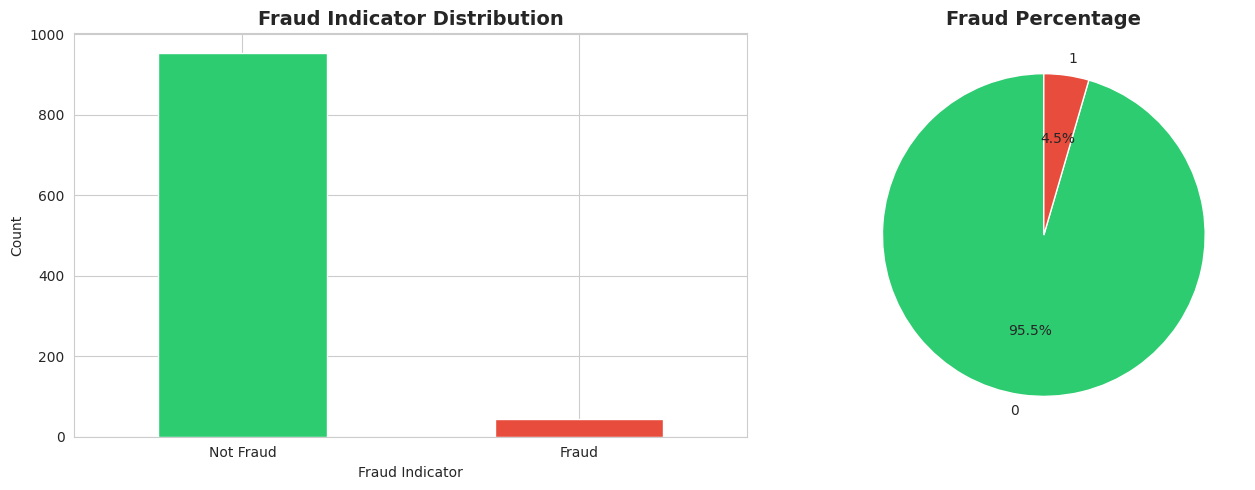

In [26]:
print("\n" + "="*80)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("="*80)

# Check for missing values
print("\nMissing Values:")
missing_vals = data.isnull().sum()
if missing_vals.sum() > 0:
    print(missing_vals[missing_vals > 0])
else:
    print("No missing values found")

# Check data types
print("\nData Types:")
print(data.dtypes.value_counts())

# Target distribution
print("\nTarget Distribution:")
print(data['FraudIndicator'].value_counts())
print(f"Fraud percentage: {data['FraudIndicator'].mean()*100:.2f}%")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
data['FraudIndicator'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Fraud Indicator Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fraud Indicator')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Not Fraud', 'Fraud'], rotation=0)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
data['FraudIndicator'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                           colors=colors, startangle=90)
axes[1].set_title('Fraud Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()


# DATA PREPROCESSING


STEP 3: DATA PREPROCESSING
Timestamp conversion complete

Outlier Detection:
  SuspiciousFlag: 25 outliers (2.50%)


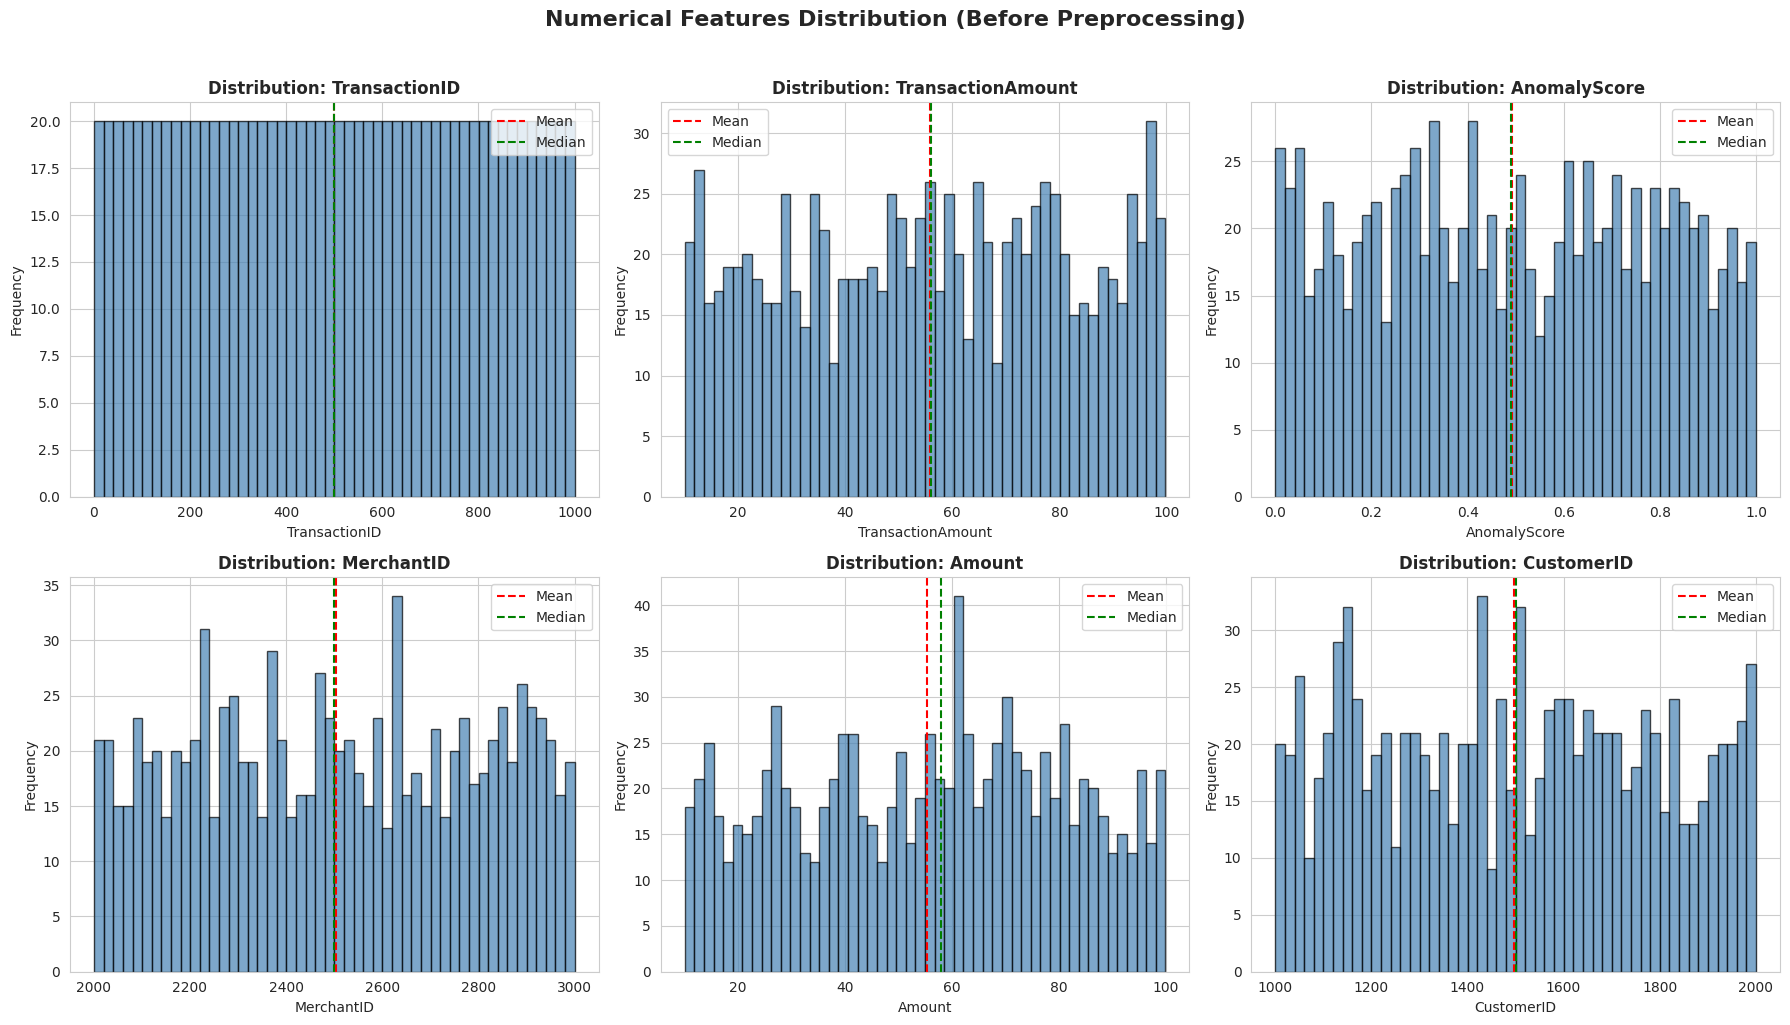

In [27]:
print("\n" + "="*80)
print("STEP 3: DATA PREPROCESSING")
print("="*80)

# Convert timestamp columns
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data['LastLogin'] = pd.to_datetime(data['LastLogin'], errors='coerce')

# Handle missing values in timestamps if any
if data['Timestamp'].isnull().sum() > 0:
    data = data.dropna(subset=['Timestamp'])
if data['LastLogin'].isnull().sum() > 0:
    data = data.dropna(subset=['LastLogin'])

print(f"Timestamp conversion complete")

# Detect and visualize outliers in numerical columns
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('FraudIndicator')  # Remove target

print("\nOutlier Detection:")
outlier_info = {}
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].count()
    outlier_info[col] = {
        'count': outliers,
        'percentage': (outliers / len(data)) * 100
    }
    if outliers > 0:
        print(f"  {col}: {outliers} outliers ({outlier_info[col]['percentage']:.2f}%)")

# Visualize distributions before preprocessing
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

numerical_to_plot = numerical_cols[:6] if len(numerical_cols) >= 6 else numerical_cols
for idx, col in enumerate(numerical_to_plot):
    axes[idx].hist(data[col].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution: {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(data[col].mean(), color='red', linestyle='--', label='Mean')
    axes[idx].axvline(data[col].median(), color='green', linestyle='--', label='Median')
    axes[idx].legend()

plt.suptitle('Numerical Features Distribution (Before Preprocessing)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# ADVANCED FEATURE ENGINEERING


STEP 4: ADVANCED FEATURE ENGINEERING

1. Creating Temporal Features...
  Created 13 temporal features

2. Creating Account Activity Features...
  Created 6 account activity features

3. Creating Amount-based Features...
  Created 9 amount-based features

4. Creating Anomaly Score Features...
  Created 5 anomaly score features

5. Creating Aggregated Features...
  Created customer-level aggregations

6. Creating Statistical Features...
  Created 5 statistical features

7. Visualizing Engineered Features...


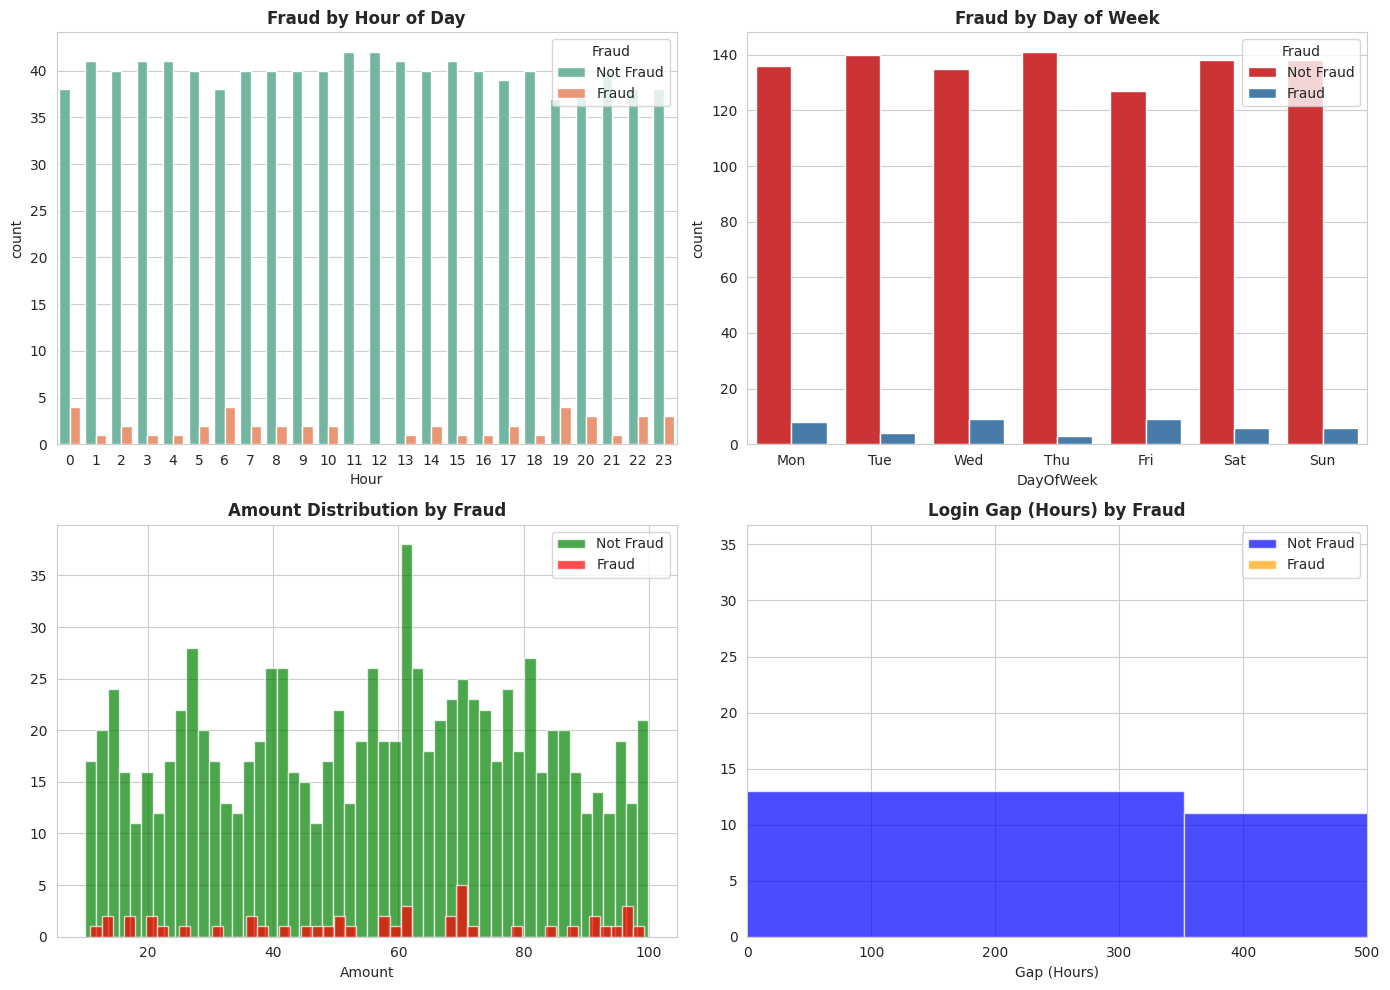

In [28]:
print("\n" + "="*80)
print("STEP 4: ADVANCED FEATURE ENGINEERING")
print("="*80)

# Temporal Features
print("\n1. Creating Temporal Features...")
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['DayOfMonth'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month
data['Quarter'] = data['Timestamp'].dt.quarter
data['Year'] = data['Timestamp'].dt.year
data['WeekOfYear'] = data['Timestamp'].dt.isocalendar().week.astype(int)

# Time-based binary features
data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)
data['IsNightTime'] = ((data['Hour'] >= 22) | (data['Hour'] <= 6)).astype(int)
data['IsBusinessHours'] = ((data['Hour'] >= 9) & (data['Hour'] <= 17)).astype(int)
data['IsLateNight'] = ((data['Hour'] >= 0) & (data['Hour'] <= 4)).astype(int)
data['IsRushHour'] = (((data['Hour'] >= 7) & (data['Hour'] <= 9)) |
                       ((data['Hour'] >= 17) & (data['Hour'] <= 19))).astype(int)
data['IsMonthEnd'] = (data['DayOfMonth'] >= 25).astype(int)
data['IsMonthStart'] = (data['DayOfMonth'] <= 5).astype(int)

print(f"  Created {7 + 6} temporal features")

# Account Activity Features
print("\n2. Creating Account Activity Features...")
data['gap_days'] = (data['Timestamp'] - data['LastLogin']).dt.days.abs()
data['gap_hours'] = (data['Timestamp'] - data['LastLogin']).dt.total_seconds() / 3600
data['gap_minutes'] = (data['Timestamp'] - data['LastLogin']).dt.total_seconds() / 60

# Categorize gap duration
data['GapCategory'] = pd.cut(data['gap_hours'],
                              bins=[-np.inf, 1, 24, 168, np.inf],
                              labels=['VeryRecent', 'Recent', 'Moderate', 'Long'])
data['GapCategory'] = data['GapCategory'].astype(str)

# Login frequency indicator
data['FrequentUser'] = (data['gap_hours'] < 24).astype(int)
data['InactiveUser'] = (data['gap_days'] > 30).astype(int)

print(f"  Created 6 account activity features")

# Amount-based Features (if Amount column exists)
if 'Amount' in data.columns:
    print("\n3. Creating Amount-based Features...")
    data['Amount_log'] = np.log1p(data['Amount'])
    data['Amount_sqrt'] = np.sqrt(data['Amount'])
    data['Amount_squared'] = data['Amount'] ** 2
    data['Amount_cubed'] = data['Amount'] ** 3

    # Binning amounts
    data['AmountCategory'] = pd.cut(data['Amount'],
                                     bins=[0, 100, 500, 1000, 5000, np.inf],
                                     labels=['VerySmall', 'Small', 'Medium', 'Large', 'VeryLarge'])
    data['AmountCategory'] = data['AmountCategory'].astype(str)

    # Z-score for amount
    data['Amount_zscore'] = (data['Amount'] - data['Amount'].mean()) / data['Amount'].std()
    data['IsHighAmount'] = (data['Amount_zscore'] > 2).astype(int)
    data['IsLowAmount'] = (data['Amount_zscore'] < -2).astype(int)

    print(f"  Created 9 amount-based features")

# Anomaly Score Features (if exists)
if 'AnomalyScore' in data.columns:
    print("\n4. Creating Anomaly Score Features...")
    data['AnomalyScore_squared'] = data['AnomalyScore'] ** 2
    data['AnomalyScore_log'] = np.log1p(data['AnomalyScore'])

    # High anomaly indicator
    anomaly_threshold = data['AnomalyScore'].quantile(0.75)
    data['HighAnomalyScore'] = (data['AnomalyScore'] > anomaly_threshold).astype(int)

    # Interaction features - SAFE DIVISION
    if 'Amount' in data.columns:
        data['Anomaly_Amount_ratio'] = data['AnomalyScore'] / (data['Amount'] + 1e-10)
        data['Anomaly_Amount_product'] = data['AnomalyScore'] * data['Amount']
        # Replace inf and nan
        data['Anomaly_Amount_ratio'] = data['Anomaly_Amount_ratio'].replace([np.inf, -np.inf], 0).fillna(0)

    print(f"  Created 5 anomaly score features")

# Aggregated Features by Customer and Merchant
print("\n5. Creating Aggregated Features...")
if 'CustomerID' in data.columns:
    customer_agg = data.groupby('CustomerID').agg({
        'Amount': ['mean', 'std', 'min', 'max', 'count'] if 'Amount' in data.columns else ['count'],
        'AnomalyScore': ['mean', 'max'] if 'AnomalyScore' in data.columns else []
    }).reset_index()
    customer_agg.columns = ['CustomerID'] + ['_'.join(col).strip() for col in customer_agg.columns[1:]]
    data = data.merge(customer_agg, on='CustomerID', how='left')
    print(f"  Created customer-level aggregations")

# Statistical Features - WITH NaN HANDLING
print("\n6. Creating Statistical Features...")
if 'Amount' in data.columns:
    # Rolling statistics - FIXED
    data = data.sort_values('Timestamp')
    data['Amount_rolling_mean_3'] = data.groupby('CustomerID')['Amount'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    ).fillna(data['Amount'])  # Fill with original amount

    data['Amount_rolling_std_3'] = data.groupby('CustomerID')['Amount'].transform(
        lambda x: x.rolling(window=3, min_periods=1).std()
    ).fillna(0)  # Fill with 0 (no variance)

    data['Amount_rolling_max_3'] = data.groupby('CustomerID')['Amount'].transform(
        lambda x: x.rolling(window=3, min_periods=1).max()
    ).fillna(data['Amount'])  # Fill with original amount

    # Deviation from personal average - SAFE DIVISION
    data['Amount_deviation_from_avg'] = data['Amount'] - data['Amount_mean']
    data['Amount_deviation_pct'] = (data['Amount_deviation_from_avg'] / (data['Amount_mean'] + 1e-10)) * 100
    data['Amount_deviation_pct'] = data['Amount_deviation_pct'].replace([np.inf, -np.inf], 0).fillna(0)

    print(f"  Created 5 statistical features")

# Visualize some engineered features
print("\n7. Visualizing Engineered Features...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hour vs Fraud
sns.countplot(data=data, x='Hour', hue='FraudIndicator', ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Fraud by Hour of Day', fontweight='bold')
axes[0, 0].legend(title='Fraud', labels=['Not Fraud', 'Fraud'])

# Day of Week vs Fraud
sns.countplot(data=data, x='DayOfWeek', hue='FraudIndicator', ax=axes[0, 1], palette='Set1')
axes[0, 1].set_title('Fraud by Day of Week', fontweight='bold')
axes[0, 1].legend(title='Fraud', labels=['Not Fraud', 'Fraud'])
axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

if 'Amount' in data.columns:
    # Amount distribution by fraud
    data[data['FraudIndicator']==0]['Amount'].hist(bins=50, ax=axes[1, 0], alpha=0.7, label='Not Fraud', color='green')
    data[data['FraudIndicator']==1]['Amount'].hist(bins=50, ax=axes[1, 0], alpha=0.7, label='Fraud', color='red')
    axes[1, 0].set_title('Amount Distribution by Fraud', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].set_xlabel('Amount')

# Gap hours distribution
data[data['FraudIndicator']==0]['gap_hours'].hist(bins=50, ax=axes[1, 1], alpha=0.7, label='Not Fraud', color='blue')
data[data['FraudIndicator']==1]['gap_hours'].hist(bins=50, ax=axes[1, 1], alpha=0.7, label='Fraud', color='orange')
axes[1, 1].set_title('Login Gap (Hours) by Fraud', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].set_xlabel('Gap (Hours)')
axes[1, 1].set_xlim(0, 500)

plt.tight_layout()
plt.show()


# CORRELATION ANALYSIS


STEP 5: CORRELATION ANALYSIS

Encoding 3 categorical features...

Top 15 Features Correlated with Fraud:
Amount_std              0.062623
IsBusinessHours         0.058956
SuspiciousFlag          0.057932
gap_minutes             0.056901
gap_hours               0.056901
gap_days                0.056658
AnomalyScore_log        0.051253
Month                   0.049960
AnomalyScore            0.048198
IsMonthEnd              0.044385
AnomalyScore_mean       0.042570
IsNightTime             0.040632
Anomaly_Amount_ratio    0.040357
AnomalyScore_squared    0.038183
Amount_rolling_std_3    0.033899
dtype: float64


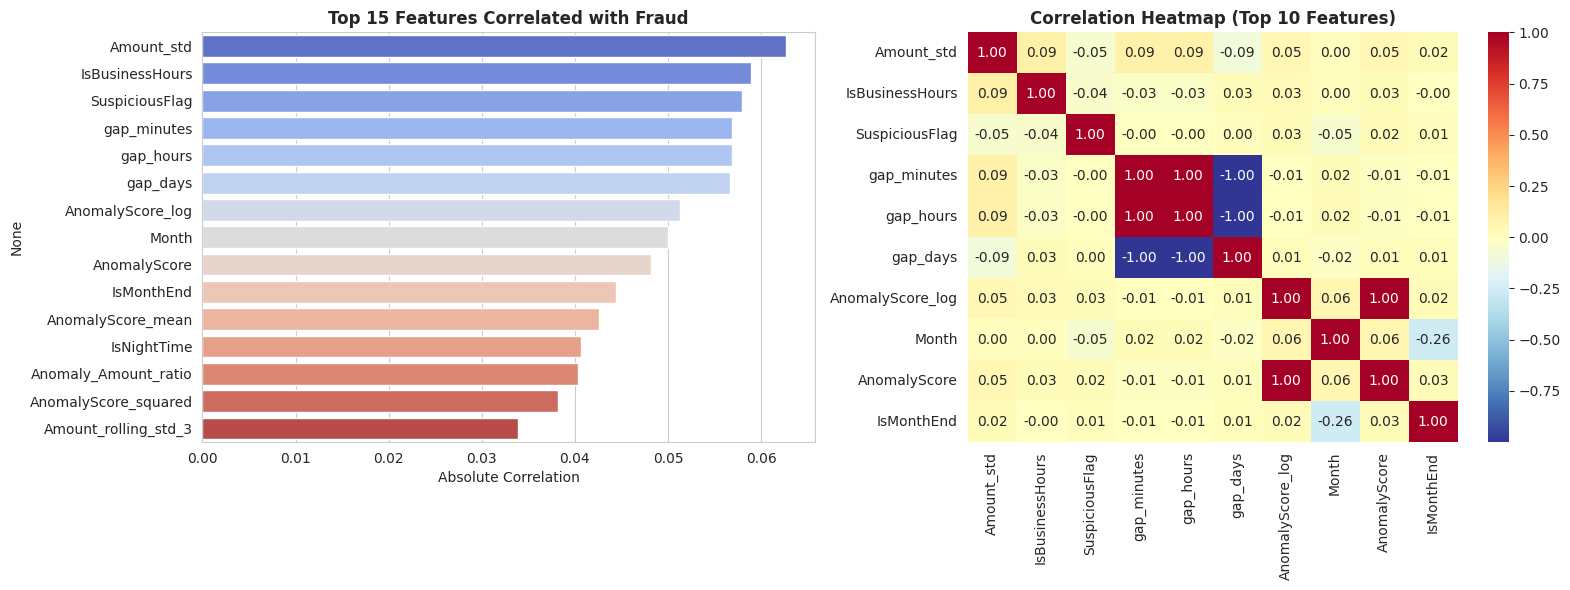

In [29]:
print("\n" + "="*80)
print("STEP 5: CORRELATION ANALYSIS")
print("="*80)

# Drop columns for modeling
columns_to_drop = ['TransactionID', 'MerchantID', 'CustomerID', 'Name', 'Age',
                   'Address', 'Timestamp', 'LastLogin']
data_clean = data.drop([col for col in columns_to_drop if col in data.columns], axis=1)

# Separate features and target
X = data_clean.drop('FraudIndicator', axis=1)
Y = data_clean['FraudIndicator']

# Encode categorical variables
label_encoders = {}
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nEncoding {len(categorical_cols)} categorical features...")

for column in categorical_cols:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le

# Correlation with target
correlation_with_target = X.corrwith(Y).abs().sort_values(ascending=False)
print("\nTop 15 Features Correlated with Fraud:")
print(correlation_with_target.head(15))

# Visualize top correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 correlations with target
top_corr = correlation_with_target.head(15)
sns.barplot(x=top_corr.values, y=top_corr.index, ax=axes[0], palette='coolwarm')
axes[0].set_title('Top 15 Features Correlated with Fraud', fontweight='bold')
axes[0].set_xlabel('Absolute Correlation')

# Correlation heatmap for top features
top_features = correlation_with_target.head(10).index.tolist()
corr_matrix = X[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[1], cbar=True)
axes[1].set_title('Correlation Heatmap (Top 10 Features)', fontweight='bold')

plt.tight_layout()
plt.show()

# FEATURE SCALING & TRANSFORMATION


In [30]:
print("\n" + "="*80)
print("STEP 6: FEATURE SCALING & TRANSFORMATION")
print("="*80)

# Separate numerical columns
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
print(f"\nScaling {len(numerical_features)} numerical features...")

# Check skewness
skewness = X[numerical_features].apply(lambda x: skew(x.dropna()))
highly_skewed = skewness[abs(skewness) > 1].sort_values(ascending=False)
print(f"\nHighly skewed features (|skew| > 1): {len(highly_skewed)}")
if len(highly_skewed) > 0:
    print(highly_skewed.head(10))

# Apply multiple scaling techniques
X_scaled = X.copy()

# Standard Scaler for normally distributed features
normal_features = skewness[abs(skewness) <= 1].index.tolist()
if len(normal_features) > 0:
    scaler_standard = StandardScaler()
    X_scaled[normal_features] = scaler_standard.fit_transform(X[normal_features])
    print(f"  StandardScaler applied to {len(normal_features)} features")

# Robust Scaler for features with outliers
robust_features = [col for col in highly_skewed.index if col not in normal_features][:10]
if len(robust_features) > 0:
    scaler_robust = RobustScaler()
    X_scaled[robust_features] = scaler_robust.fit_transform(X[robust_features])
    print(f"  RobustScaler applied to {len(robust_features)} features")

# Power Transformer for highly skewed features
remaining_skewed = [col for col in highly_skewed.index if col not in robust_features]
if len(remaining_skewed) > 0:
    # Ensure all values are positive for PowerTransformer
    for col in remaining_skewed:
        if X_scaled[col].min() <= 0:
            X_scaled[col] = X_scaled[col] - X_scaled[col].min() + 1

    power_transformer = PowerTransformer(method='yeo-johnson')
    X_scaled[remaining_skewed] = power_transformer.fit_transform(X_scaled[remaining_skewed])
    print(f"  PowerTransformer applied to {len(remaining_skewed)} features")



STEP 6: FEATURE SCALING & TRANSFORMATION

Scaling 51 numerical features...

Highly skewed features (|skew| > 1): 14
SuspiciousFlag          6.084870
WeekOfYear              4.067330
Anomaly_Amount_ratio    2.236426
IsMonthEnd              1.776036
Amount_rolling_std_3    1.687289
IsLateNight             1.423983
Amount_count            1.304540
IsMonthStart            1.217562
IsRushHour              1.160871
HighAnomalyScore        1.154701
dtype: float64
  StandardScaler applied to 32 features
  RobustScaler applied to 10 features
  PowerTransformer applied to 4 features


# CRITICAL: HANDLE NaN AND INFINITE VALUES

In [31]:
print("\n" + "="*80)
print("STEP 6.5: HANDLING NaN AND INFINITE VALUES")
print("="*80)

# Check for NaN values
print("\nChecking for NaN values in scaled data...")
nan_counts = X_scaled.isnull().sum()
nan_columns = nan_counts[nan_counts > 0]

if len(nan_columns) > 0:
    print(f"\nFound NaN values in {len(nan_columns)} columns:")
    print(nan_columns)

    # Strategy 1: Fill NaN in rolling statistics with 0 (represents no history)
    rolling_cols = [col for col in X_scaled.columns if 'rolling' in col.lower()]
    if rolling_cols:
        print(f"\nFilling {len(rolling_cols)} rolling statistic columns with 0...")
        X_scaled[rolling_cols] = X_scaled[rolling_cols].fillna(0)

    # Strategy 2: Fill NaN in deviation columns with 0 (no deviation)
    deviation_cols = [col for col in X_scaled.columns if 'deviation' in col.lower()]
    if deviation_cols:
        print(f"Filling {len(deviation_cols)} deviation columns with 0...")
        X_scaled[deviation_cols] = X_scaled[deviation_cols].fillna(0)

    # Strategy 3: Fill NaN in ratio/division columns with 0
    ratio_cols = [col for col in X_scaled.columns if any(x in col.lower() for x in ['ratio', '_pct', 'anomaly_amount'])]
    if ratio_cols:
        print(f"Filling {len(ratio_cols)} ratio columns with 0...")
        X_scaled[ratio_cols] = X_scaled[ratio_cols].fillna(0)

    # Strategy 4: Fill remaining NaN with median for numerical columns
    remaining_nan = X_scaled.isnull().sum()
    remaining_nan_cols = remaining_nan[remaining_nan > 0].index.tolist()

    if remaining_nan_cols:
        print(f"\nFilling remaining {len(remaining_nan_cols)} columns with median...")
        for col in remaining_nan_cols:
            median_val = X_scaled[col].median()
            if pd.isna(median_val):
                median_val = 0
            X_scaled[col] = X_scaled[col].fillna(median_val)

    # Final check
    final_nan_count = X_scaled.isnull().sum().sum()
    print(f"\nFinal NaN count after filling: {final_nan_count}")

    if final_nan_count > 0:
        print("WARNING: Still have NaN values. Dropping rows with NaN...")
        X_scaled = X_scaled.dropna()
        Y = Y.loc[X_scaled.index]
        print(f"New dataset shape: {X_scaled.shape}")
else:
    print("No NaN values found!")

# Check for infinite values
print("\nChecking for infinite values...")
inf_mask = np.isinf(X_scaled.select_dtypes(include=[np.number]).values).any(axis=1)
if inf_mask.sum() > 0:
    print(f"Found {inf_mask.sum()} rows with infinite values. Replacing with large finite values...")
    X_scaled = X_scaled.replace([np.inf, -np.inf], [1e10, -1e10])

# Final comprehensive check
print("\n Final Data Quality Check:")
print(f"  Shape: {X_scaled.shape}")
print(f"  NaN count: {X_scaled.isnull().sum().sum()}")
print(f"  Inf count: {np.isinf(X_scaled.select_dtypes(include=[np.number]).values).sum()}")
print(f"  Data type consistency: {'OK' if X_scaled.select_dtypes(include=[np.number]).shape[1] == X_scaled.shape[1] else 'CHECK'}")



STEP 6.5: HANDLING NaN AND INFINITE VALUES

Checking for NaN values in scaled data...

Found NaN values in 1 columns:
Amount_std    379
dtype: int64

Filling 3 rolling statistic columns with 0...
Filling 2 deviation columns with 0...
Filling 3 ratio columns with 0...

Filling remaining 1 columns with median...

Final NaN count after filling: 0

Checking for infinite values...

 Final Data Quality Check:
  Shape: (1000, 51)
  NaN count: 0
  Inf count: 0
  Data type consistency: OK


# HANDLE CLASS IMBALANCE



STEP 7: HANDLING CLASS IMBALANCE

Original class distribution:
  Not Fraud: 955 (95.50%)
  Fraud: 45 (4.50%)

Applying SMOTE...

After resampling:
  Not Fraud: 955 (55.56%)
  Fraud: 764 (44.44%)
  Total samples: 1719


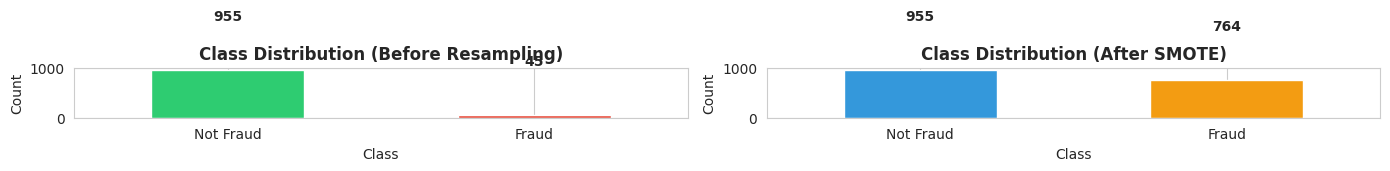

In [32]:
print("\n" + "="*80)
print("STEP 7: HANDLING CLASS IMBALANCE")
print("="*80)

print(f"\nOriginal class distribution:")
print(f"  Not Fraud: {(Y==0).sum()} ({(Y==0).sum()/len(Y)*100:.2f}%)")
print(f"  Fraud: {(Y==1).sum()} ({(Y==1).sum()/len(Y)*100:.2f}%)")

# Apply SMOTE for oversampling
print("\nApplying SMOTE...")
smote = SMOTE(random_state=42, sampling_strategy=0.8)
X_resampled, y_resampled = smote.fit_resample(X_scaled, Y)

print(f"\nAfter resampling:")
print(f"  Not Fraud: {(y_resampled==0).sum()} ({(y_resampled==0).sum()/len(y_resampled)*100:.2f}%)")
print(f"  Fraud: {(y_resampled==1).sum()} ({(y_resampled==1).sum()/len(y_resampled)*100:.2f}%)")
print(f"  Total samples: {len(y_resampled)}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before resampling
Y.value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (Before Resampling)', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Not Fraud', 'Fraud'], rotation=0)
for i, v in enumerate(Y.value_counts()):
    axes[0].text(i, v + 1000, str(v), ha='center', fontweight='bold')

# After resampling
pd.Series(y_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['#3498db', '#f39c12'])
axes[1].set_title('Class Distribution (After SMOTE)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Not Fraud', 'Fraud'], rotation=0)
for i, v in enumerate(pd.Series(y_resampled).value_counts()):
    axes[1].text(i, v + 1000, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


# TRAIN-TEST SPLIT



In [33]:

print("\n" + "="*80)
print("STEP 8: TRAIN-TEST SPLIT")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")



STEP 8: TRAIN-TEST SPLIT
Training set size: (1289, 51)
Test set size: (430, 51)
Number of features: 51


# MODEL TRAINING - ENSEMBLE APPROACH


In [34]:

print("\n" + "="*80)
print("STEP 9: MODEL TRAINING")
print("="*80)

models_performance = {}

# 1. Random Forest
print("\n1. Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    bootstrap=True
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

models_performance['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred)
}

print("Random Forest Results:")
for metric, value in models_performance['Random Forest'].items():
    print(f"  {metric.capitalize()}: {value:.4f} ({value*100:.2f}%)")

# 2. Gradient Boosting
print("\n2. Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    max_features='sqrt',
    random_state=42
)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

models_performance['Gradient Boosting'] = {
    'accuracy': accuracy_score(y_test, gb_pred),
    'precision': precision_score(y_test, gb_pred),
    'recall': recall_score(y_test, gb_pred),
    'f1': f1_score(y_test, gb_pred)
}

print("Gradient Boosting Results:")
for metric, value in models_performance['Gradient Boosting'].items():
    print(f"  {metric.capitalize()}: {value:.4f} ({value*100:.2f}%)")

# 3. Decision Tree
print("\n3. Training Decision Tree Classifier...")
dt_model = DecisionTreeClassifier(
    max_depth=20,
    min_samples_split=15,
    min_samples_leaf=8,
    criterion='gini',
    random_state=42,
    class_weight='balanced',
    splitter='best'
)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

models_performance['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, dt_pred),
    'precision': precision_score(y_test, dt_pred),
    'recall': recall_score(y_test, dt_pred),
    'f1': f1_score(y_test, dt_pred)
}

print("Decision Tree Results:")
for metric, value in models_performance['Decision Tree'].items():
    print(f"  {metric.capitalize()}: {value:.4f} ({value*100:.2f}%)")

# 4. Ensemble Voting Classifier
print("\n4. Training Ensemble Voting Classifier...")
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('dt', dt_model)
    ],
    voting='soft',
    weights=[2, 2, 1]  # Give more weight to RF and GB
)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)

models_performance['Ensemble Voting'] = {
    'accuracy': accuracy_score(y_test, voting_pred),
    'precision': precision_score(y_test, voting_pred),
    'recall': recall_score(y_test, voting_pred),
    'f1': f1_score(y_test, voting_pred)
}

print("Ensemble Voting Results:")
for metric, value in models_performance['Ensemble Voting'].items():
    print(f"  {metric.capitalize()}: {value:.4f} ({value*100:.2f}%)")



STEP 9: MODEL TRAINING

1. Training Random Forest Classifier...
Random Forest Results:
  Accuracy: 0.9721 (97.21%)
  Precision: 0.9838 (98.38%)
  Recall: 0.9529 (95.29%)
  F1: 0.9681 (96.81%)

2. Training Gradient Boosting Classifier...
Gradient Boosting Results:
  Accuracy: 0.9860 (98.60%)
  Precision: 0.9947 (99.47%)
  Recall: 0.9738 (97.38%)
  F1: 0.9841 (98.41%)

3. Training Decision Tree Classifier...
Decision Tree Results:
  Accuracy: 0.8977 (89.77%)
  Precision: 0.8930 (89.30%)
  Recall: 0.8743 (87.43%)
  F1: 0.8836 (88.36%)

4. Training Ensemble Voting Classifier...
Ensemble Voting Results:
  Accuracy: 0.9814 (98.14%)
  Precision: 0.9946 (99.46%)
  Recall: 0.9634 (96.34%)
  F1: 0.9787 (97.87%)


# MODEL COMPARISON




STEP 10: MODEL COMPARISON

Model Performance Comparison:
                   accuracy  precision  recall      f1
Random Forest        0.9721     0.9838  0.9529  0.9681
Gradient Boosting    0.9860     0.9947  0.9738  0.9841
Decision Tree        0.8977     0.8930  0.8743  0.8836
Ensemble Voting      0.9814     0.9946  0.9634  0.9787


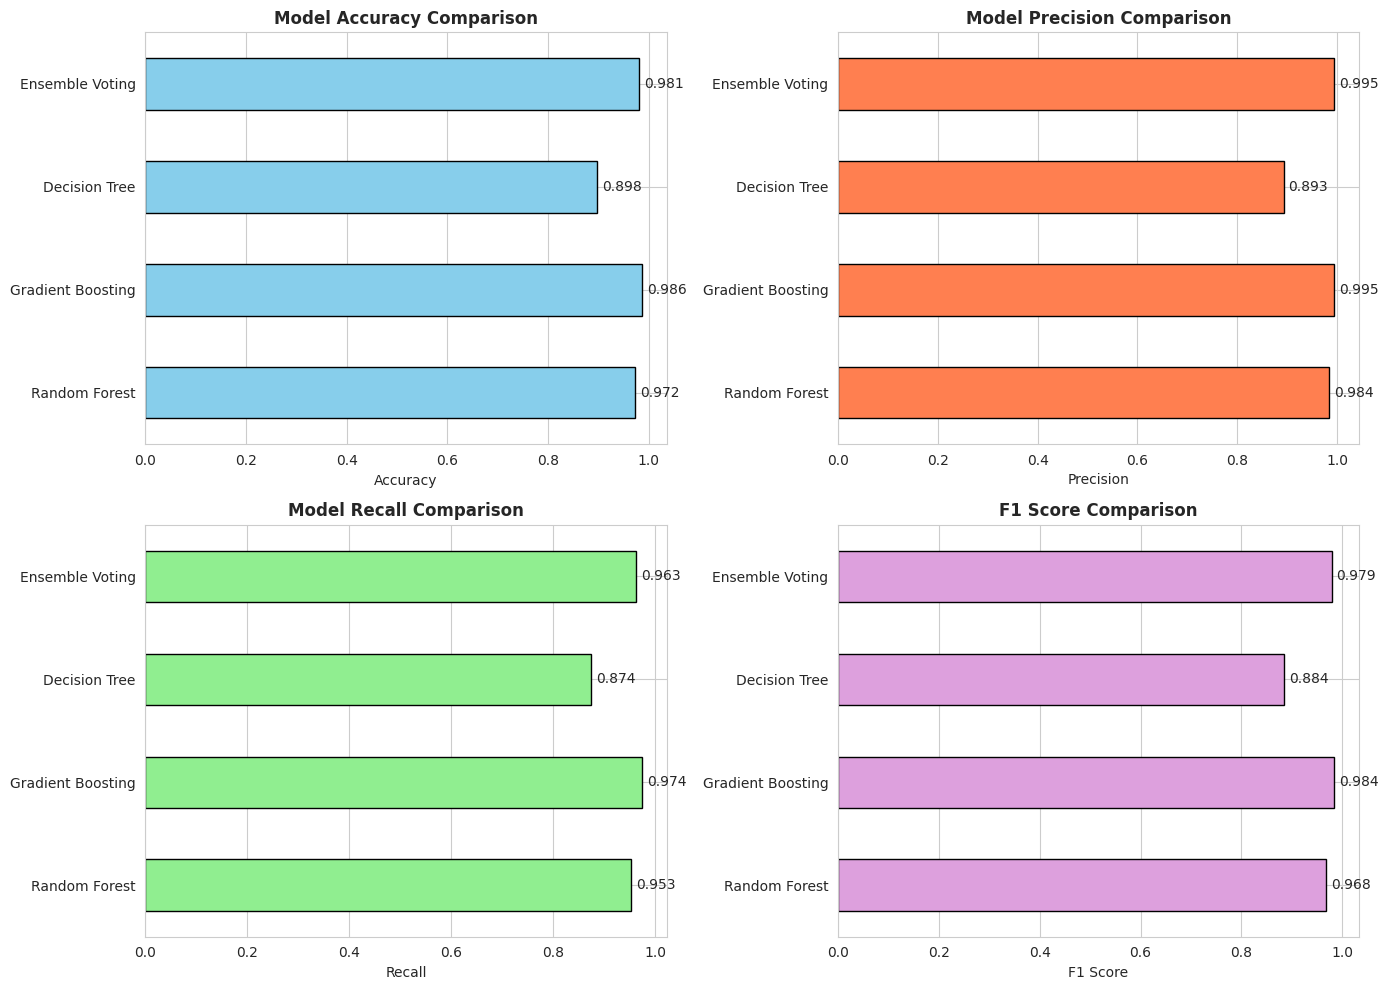

In [35]:

print("\n" + "="*80)
print("STEP 10: MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame(models_performance).T
print("\nModel Performance Comparison:")
print(comparison_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
comparison_df['accuracy'].plot(kind='barh', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0, 0].set_xlabel('Accuracy')
for i, v in enumerate(comparison_df['accuracy']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Precision comparison
comparison_df['precision'].plot(kind='barh', ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_title('Model Precision Comparison', fontweight='bold')
axes[0, 1].set_xlabel('Precision')
for i, v in enumerate(comparison_df['precision']):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# Recall comparison
comparison_df['recall'].plot(kind='barh', ax=axes[1, 0], color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Model Recall Comparison', fontweight='bold')
axes[1, 0].set_xlabel('Recall')
for i, v in enumerate(comparison_df['recall']):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# F1 Score comparison
comparison_df['f1'].plot(kind='barh', ax=axes[1, 1], color='plum', edgecolor='black')
axes[1, 1].set_title('F1 Score Comparison', fontweight='bold')
axes[1, 1].set_xlabel('F1 Score')
for i, v in enumerate(comparison_df['f1']):
    axes[1, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()


# DETAILED EVALUATION OF BEST MODEL (ENSEMBLE)



STEP 11: DETAILED EVALUATION - ENSEMBLE MODEL

Confusion Matrix:
[[238   1]
 [  7 184]]

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.97      1.00      0.98       239
       Fraud       0.99      0.96      0.98       191

    accuracy                           0.98       430
   macro avg       0.98      0.98      0.98       430
weighted avg       0.98      0.98      0.98       430



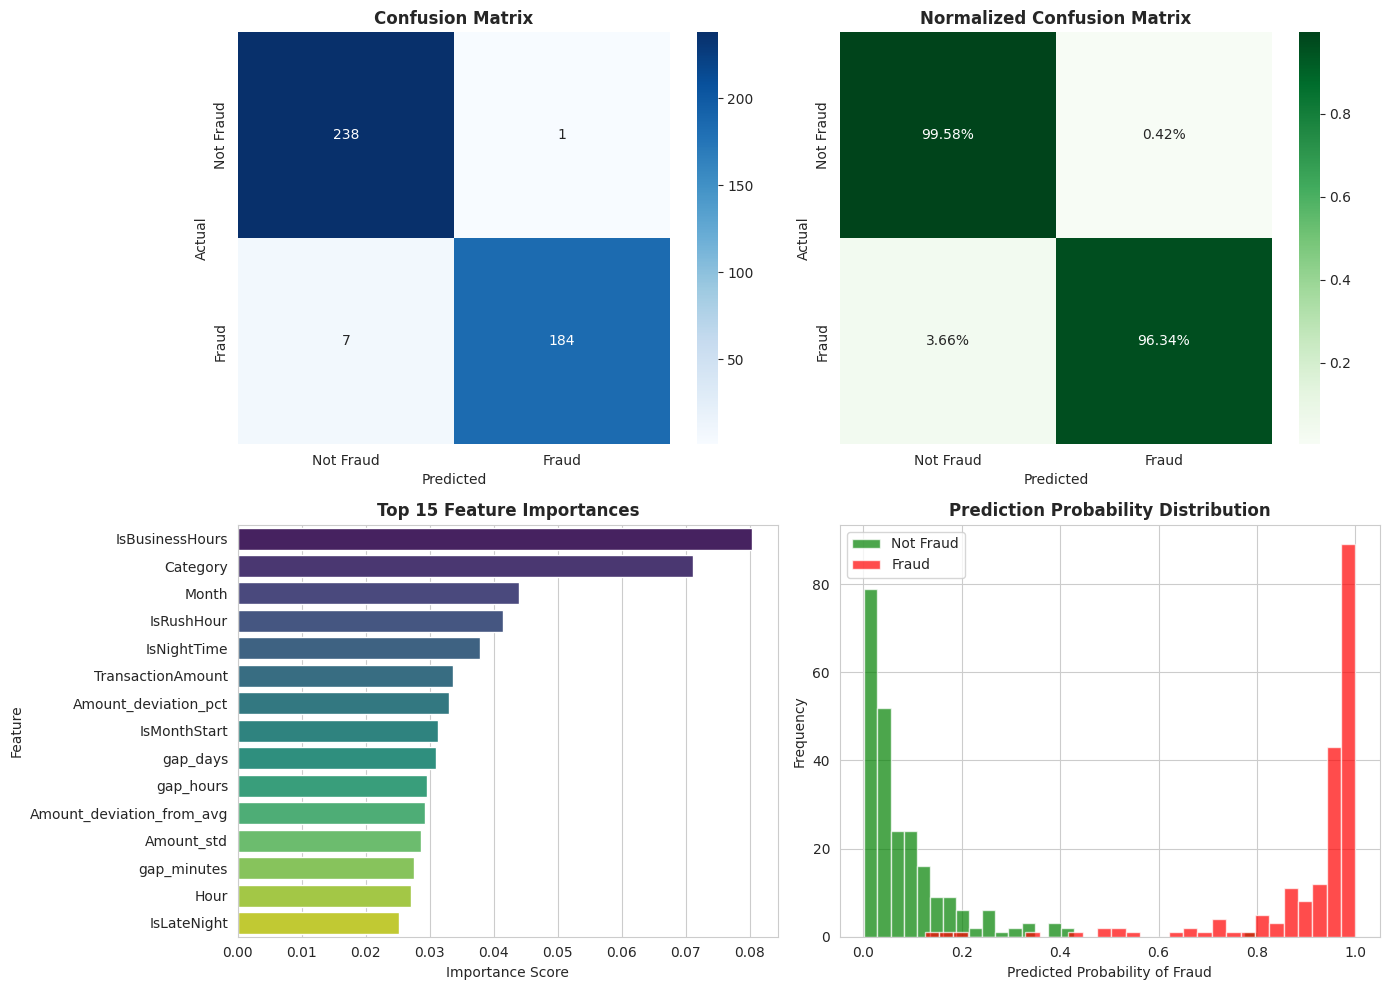

In [36]:
print("\n" + "="*80)
print("STEP 11: DETAILED EVALUATION - ENSEMBLE MODEL")
print("="*80)

# Confusion Matrix
confusion = confusion_matrix(y_test, voting_pred)
print("\nConfusion Matrix:")
print(confusion)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, voting_pred,
                          target_names=['Not Fraud', 'Fraud']))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix Heatmap
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'], ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix', fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# 2. Normalized Confusion Matrix
confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_normalized, annot=True, fmt='.2%', cmap='Greens', cbar=True,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'], ax=axes[0, 1])
axes[0, 1].set_title('Normalized Confusion Matrix', fontweight='bold')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xlabel('Predicted')

# 3. Feature Importance (Random Forest)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

sns.barplot(data=feature_importance, y='feature', x='importance', ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Top 15 Feature Importances', fontweight='bold')
axes[1, 0].set_xlabel('Importance Score')
axes[1, 0].set_ylabel('Feature')

# 4. Prediction Probability Distribution
voting_proba = voting_clf.predict_proba(X_test)[:, 1]
fraud_probs = voting_proba[y_test == 1]
not_fraud_probs = voting_proba[y_test == 0]
axes[1, 1].hist(not_fraud_probs, bins=30, alpha=0.7, label='Not Fraud', color='green')
axes[1, 1].hist(fraud_probs, bins=30, alpha=0.7, label='Fraud', color='red')
axes[1, 1].set_xlabel('Predicted Probability of Fraud')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Prediction Probability Distribution', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


# CROSS-VALIDATION



STEP 12: CROSS-VALIDATION

Performing 5-Fold Cross-Validation on Ensemble Model...

Cross-Validation Scores: [0.99127907 0.98546512 0.97674419 0.98837209 0.9941691 ]
Mean CV Accuracy: 0.9872 (+/- 0.0120)
Min CV Accuracy: 0.9767
Max CV Accuracy: 0.9942


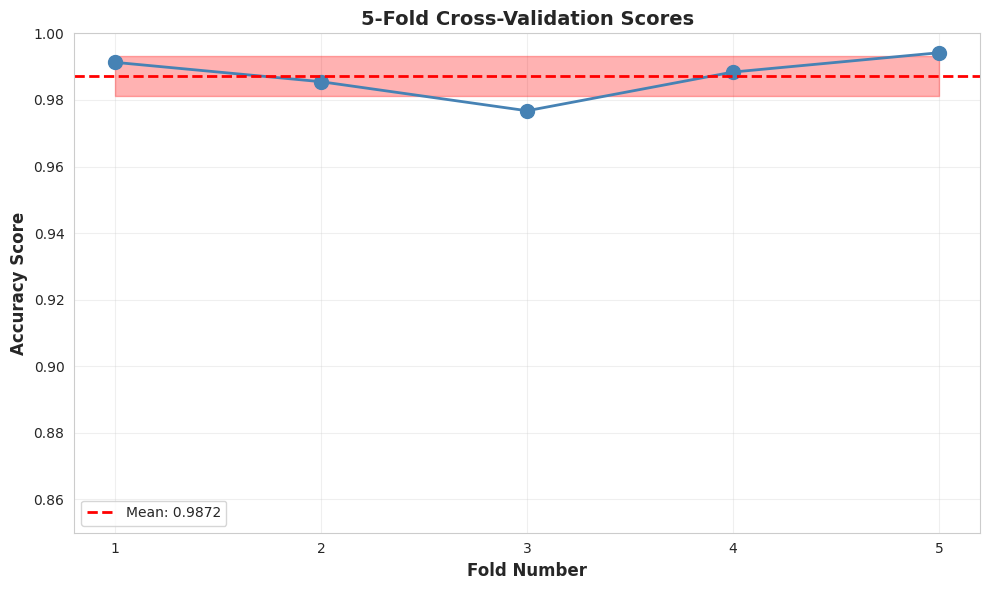

In [37]:
print("\n" + "="*80)
print("STEP 12: CROSS-VALIDATION")
print("="*80)

print("\nPerforming 5-Fold Cross-Validation on Ensemble Model...")
cv_scores = cross_val_score(voting_clf, X_resampled, y_resampled,
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                           scoring='accuracy', n_jobs=-1)

print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Min CV Accuracy: {cv_scores.min():.4f}")
print(f"Max CV Accuracy: {cv_scores.max():.4f}")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=10, color='steelblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 6), cv_scores.mean() - cv_scores.std(),
                 cv_scores.mean() + cv_scores.std(), alpha=0.3, color='red')
plt.xlabel('Fold Number', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy Score', fontsize=12, fontweight='bold')
plt.title('5-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.xticks(range(1, 6))
plt.ylim([0.85, 1.0])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# INFERENCE ON NEW DATA

In [38]:
print("\n" + "="*80)
print("STEP 13: INFERENCE EXAMPLE")
print("="*80)

# Select random samples for inference
sample_indices = np.random.choice(X_test.shape[0], size=5, replace=False)
samples = X_test.iloc[sample_indices]
actual_labels = y_test.iloc[sample_indices]

print("\nMaking predictions on 5 random test samples:\n")
print("-" * 80)

for idx, (sample_idx, sample) in enumerate(zip(sample_indices, samples.values)):
    sample_reshaped = sample.reshape(1, -1)

    # Predictions
    prediction = voting_clf.predict(sample_reshaped)[0]
    proba = voting_clf.predict_proba(sample_reshaped)[0]

    # Actual
    actual = actual_labels.iloc[idx]

    # Status
    status = "CORRECT" if prediction == actual else "INCORRECT"
    fraud_label = "FRAUD" if prediction == 1 else "NOT FRAUD"
    actual_label = "FRAUD" if actual == 1 else "NOT FRAUD"

    print(f"Sample {idx + 1}:")
    print(f"  Prediction:        {fraud_label}")
    print(f"  Actual:            {actual_label}")
    print(f"  Status:            {status}")
    print(f"  Fraud Probability: {proba[1]*100:.2f}%")
    print(f"  Confidence:        {max(proba)*100:.2f}%")
    print("-" * 80)



STEP 13: INFERENCE EXAMPLE

Making predictions on 5 random test samples:

--------------------------------------------------------------------------------
Sample 1:
  Prediction:        NOT FRAUD
  Actual:            NOT FRAUD
  Status:            CORRECT
  Fraud Probability: 18.82%
  Confidence:        81.18%
--------------------------------------------------------------------------------
Sample 2:
  Prediction:        FRAUD
  Actual:            FRAUD
  Status:            CORRECT
  Fraud Probability: 97.17%
  Confidence:        97.17%
--------------------------------------------------------------------------------
Sample 3:
  Prediction:        NOT FRAUD
  Actual:            NOT FRAUD
  Status:            CORRECT
  Fraud Probability: 4.76%
  Confidence:        95.24%
--------------------------------------------------------------------------------
Sample 4:
  Prediction:        FRAUD
  Actual:            FRAUD
  Status:            CORRECT
  Fraud Probability: 97.65%
  Confidence:     

# THRESHOLD OPTIMIZATION



STEP 14: THRESHOLD OPTIMIZATION

Performance at Different Thresholds:
   threshold  accuracy  precision  recall      f1
0       0.30    0.9698     0.9495  0.9843  0.9666
1       0.35    0.9767     0.9689  0.9791  0.9740
2       0.40    0.9814     0.9791  0.9791  0.9791
3       0.45    0.9860     0.9947  0.9738  0.9841
4       0.50    0.9814     0.9946  0.9634  0.9787
5       0.55    0.9744     0.9945  0.9476  0.9705
6       0.60    0.9744     0.9945  0.9476  0.9705
7       0.65    0.9721     0.9945  0.9424  0.9677
8       0.70    0.9651     0.9944  0.9267  0.9593
9       0.75    0.9558     0.9943  0.9058  0.9479

Optimal Threshold for F1 Score: 0.45
F1 Score at Optimal Threshold: 0.9841


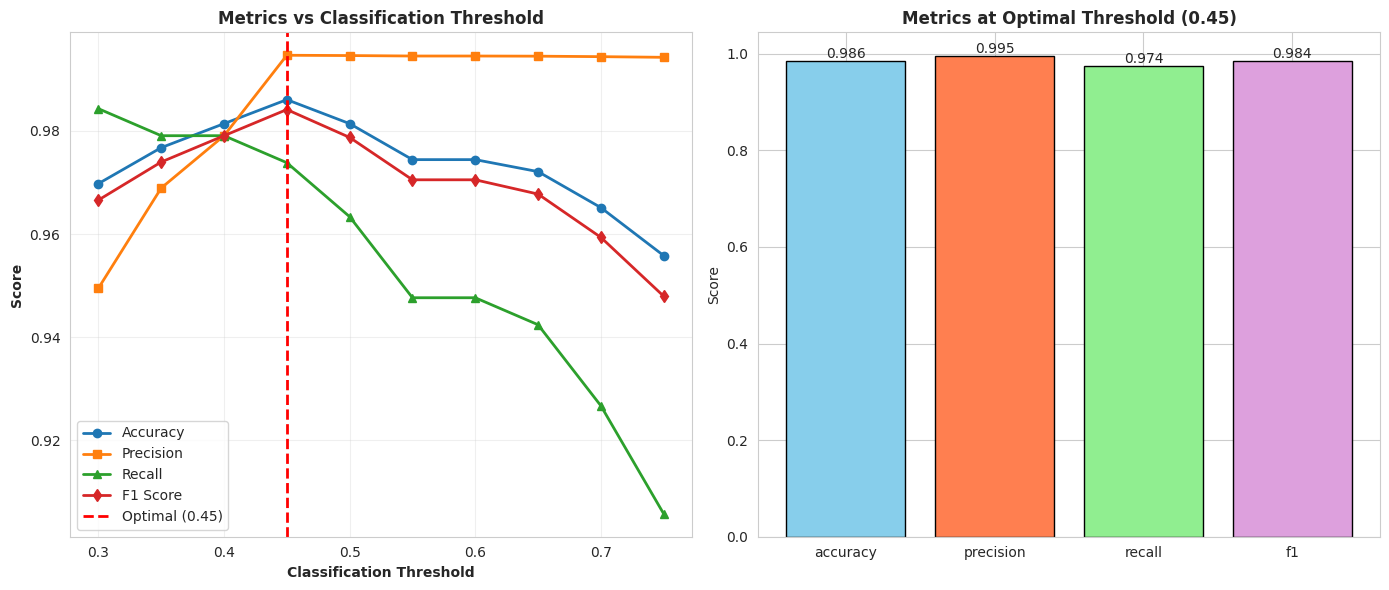

In [39]:
print("\n" + "="*80)
print("STEP 14: THRESHOLD OPTIMIZATION")
print("="*80)

# Calculate metrics for different thresholds
thresholds = np.arange(0.3, 0.8, 0.05)
threshold_metrics = []

for threshold in thresholds:
    pred_threshold = (voting_proba >= threshold).astype(int)
    threshold_metrics.append({
        'threshold': threshold,
        'accuracy': accuracy_score(y_test, pred_threshold),
        'precision': precision_score(y_test, pred_threshold),
        'recall': recall_score(y_test, pred_threshold),
        'f1': f1_score(y_test, pred_threshold)
    })

threshold_df = pd.DataFrame(threshold_metrics)
print("\nPerformance at Different Thresholds:")
print(threshold_df.round(4))

# Find optimal threshold for F1
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
print(f"\nOptimal Threshold for F1 Score: {optimal_threshold:.2f}")
print(f"F1 Score at Optimal Threshold: {threshold_df.loc[optimal_idx, 'f1']:.4f}")

# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Line plot for all metrics
ax = axes[0]
ax.plot(threshold_df['threshold'], threshold_df['accuracy'], marker='o', label='Accuracy', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['precision'], marker='s', label='Precision', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['recall'], marker='^', label='Recall', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['f1'], marker='d', label='F1 Score', linewidth=2)
ax.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.2f})')
ax.set_xlabel('Classification Threshold', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Metrics vs Classification Threshold', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Bar chart for optimal threshold metrics
ax = axes[1]
optimal_metrics = threshold_df.loc[optimal_idx, ['accuracy', 'precision', 'recall', 'f1']]
bars = ax.bar(optimal_metrics.index, optimal_metrics.values,
              color=['skyblue', 'coral', 'lightgreen', 'plum'], edgecolor='black')
ax.set_title(f'Metrics at Optimal Threshold ({optimal_threshold:.2f})', fontweight='bold')
ax.set_ylabel('Score')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
